In [1]:
!python3 -m spacy download ru_core_news_sm -q

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
) # Метрики оценки модели

✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
df = pd.read_csv('/content/1000comments.csv')
df.head()

,text,is_bias
0,Драное твоё очко. Победу одержал Советский нар...,0
1,"Тупые бараны каждый год туда катаются,потом ск...",0
2,Бля все сдохнут. Равенства никогда не будет. Н...,0
3,"Получается:протестанты ,которые зарождали капи...",1
4,"Ты че порвался, выблядок? А кем были горбатый ...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     767 non-null    object
 1   is_bias  767 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ KB


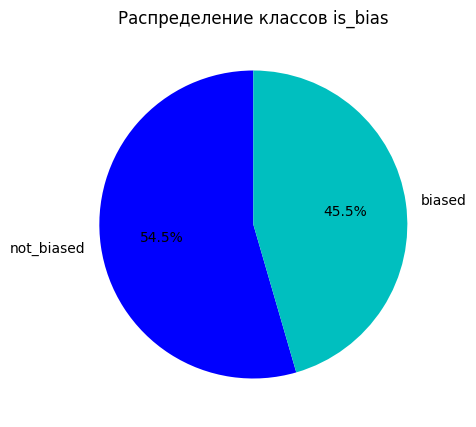

In [4]:
vis = df['is_bias'].value_counts()   # подсчет значений (1 и 0)
labels = ['not_biased', 'biased']
fig = plt.figure(figsize=(5, 5))
plt.title('Распределение классов is_bias')
plt.pie(vis, labels=labels, colors=['b', 'c'], autopct='%1.1f%%', startangle=90)
plt.show()

1. Предобработка данных.

In [5]:
nlp = spacy.load("ru_core_news_sm")
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_column0 = df['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()     #чистим колонку с текстом от пунктуации и спец. символов + убираем двойные пробелы + нижний регистр
#df_column0.head(10)

In [7]:
lemma = []   #лемматизация

for doc in nlp.pipe(df_column0.values):             #.pipe() - для эффективной обработки нескольких текстов одновременно
    lemma.append([n.lemma_ for n in doc])           #проходимся по текстам и добавляем в список

df['text'] = lemma                                 #сохраняем лемм. колонку в датафрейм
#df['text'].head()

In [8]:
stopwords_ru = stopwords.words("russian")
#stopwords_ru[0:11]

In [9]:
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stopwords_ru])      #.apply() — применяет функцию ко всем элементам колонки
df['text'] = [' '.join(map(str, l)) for l in df['text']]                                       #сделали из списков строки
df['text'].head()

,text
0,драный твой очко победа одержать советский нар...
1,тупой бараны каждый год туда кататься скулят
2,бля сдохнуть равенство это весь человек брат в...
3,получаться протестант которые зарождали капита...
4,че порваться выблядок горбатый ельцин пиздабол...


2. Векторизация

In [10]:
vec = TfidfVectorizer()  #создаем объект TfidfVectorizer
text_vec = vec.fit_transform(df['text'])  #обучаем и преобразуем

3. Обучаем модель. Бинарная логистическая регрессия.

In [11]:
X = text_vec        #данные
y = df['is_bias']   #метки с бинарным значением

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, stratify=y, random_state=42
    )

In [13]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)  # предсказания

print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Performance
Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        84
           1       0.84      0.67      0.75        70

    accuracy                           0.79       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.80      0.79      0.79       154



Видим, что модель чуть лучше схватывает класс 0, но в целом уверенно работает на обоих классах.

5. Наивный Байесовский классификатор

In [14]:
# GaussianNB ругался, что он не работает со спарс-матрицами, поэтому конвертируем в плотный формат
X_train_dense = X_train.toarray()
X_test_dense  = X_test.toarray()

nb = GaussianNB()
nb.fit(X_train_dense, y_train)

y_pred_nb = nb.predict(X_test_dense)

print("Naïve Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Performance:
Accuracy: 0.564935064935065
              precision    recall  f1-score   support

           0       0.63      0.50      0.56        84
           1       0.52      0.64      0.57        70

    accuracy                           0.56       154
   macro avg       0.57      0.57      0.56       154
weighted avg       0.58      0.56      0.56       154



4. Визуализация результатов.

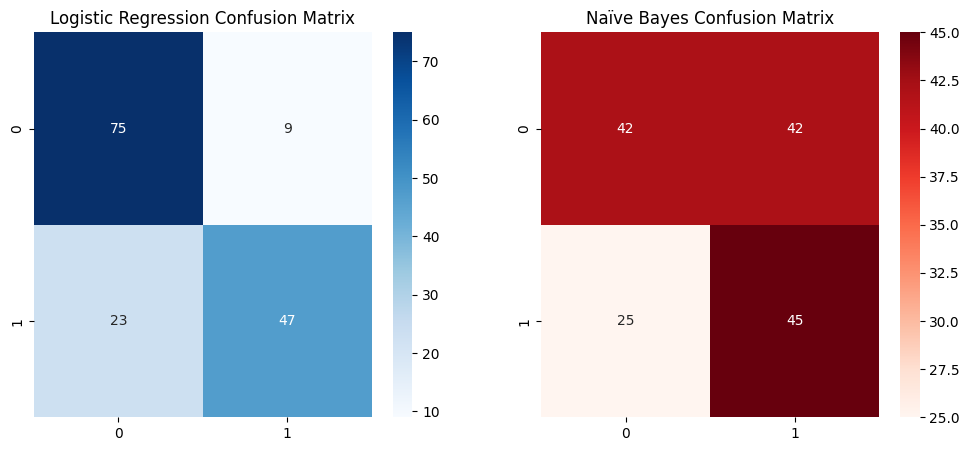

In [15]:
conf_matrix_log = confusion_matrix(y_test, y_pred_log)  # confusion_matrix для результатов логистической регрессии
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb) # confusion_matrix для результатов байесовского классификатора

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Naïve Bayes Confusion Matrix")

plt.show()